# Segmentación de regiones tumorales
### Resumen
La clasificación automática del tejido canceroso en una región de interés (ROI), desempeña un papel importante en el diagnóstico asistido por computadora. En el presente estudio, nos centramos en la segmentación de tumores cerebrales de tipo meningioma sobre imágenes de resonancia magnetica (MRI) potenciadas en T1. El data set usado cuenta con 708 imagenes, adquiridas de una basa de datos abierta del hospital general Tianjing Medical University de China, entre los años 2005 a 2010. Las imágenes tienen una resolución en el plano de 512 × 512. El borde del tumor fue delineado manualmente por tres radiólogos experimentados, generando las mascaras de los tumores. Dentro del dataset nombrado como l1 se encuentran subcarpetas nombradas mediante números que indican la pertencia a un paciente especifico. A su vez, esta contiene dos carpetas: imagen y mask. La carpeta imagen contiene la imagen de resonancia magnetica estructural con extención bmp y en cuanto a la carpeta mask contiene la imagen binaria de la mascara que limitan el tumor.
### Justificación
Los tumores cerebrales muestran grandes variaciones en la apariencia (por ejemplo, forma, tamaño e intensidad), por lo que no es posible segmentarlos mediante formas geometricas simples. Las redes neuronales convolucionales cuentan con capas de extracción de características compuesta de neuronas convolucionales. Según progresan los datos a lo largo de la arquitectura son menos sensibles a perturbaciones en los datos de entrada, pero al mismo tiempo permiten resaltar características cada vez más complejas. Estos atributos, pueden aprovecharse para delimitar de manera apropiada regiones con areas irregulares, como las que caracterizan a los tumores de tipo mengioma. 

![Meningioma](./Figuras/Meningiomas.png "Meningioma delimitado")

In [1]:
#Cargar todas las librerias
!pip install tqdm
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
import cv2
print tf.__version__

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/opt/miniconda/lib/python2.7/site-packages/skimage/measure/_marching_cubes_lewiner.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _marching_cubes_lewiner_cy
/opt/miniconda/lib/python2.7/site-packages/skimage/measure/_marching_cubes_classic.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _marching_cubes_classic_cy
/opt/miniconda/lib/python2.7/site-packages/skimage/measure/_label.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ccomp import label_cython as clabel
/opt/miniconda/lib/python2.7/site-packages/skimage/measure/pnpoly.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._pnpoly import _grid_points_in_poly, _points_in_poly
/opt/miniconda/lib/python2.7/site-packages/skimage/transform/hough_transform.py:4: Runtim

1.9.0


### Download dataset de MRI
El dataset usado para el análisis en este proyecto, se encuentra compartido en dropbox. El enlace para su descarga es: https://www.dropbox.com/s/3qqvl3hq4wkr1rx/l1.zip?dl=1, el siguiente fragmento de código se encarga de bajar los archivos y crear un directorio contenedor en su espacio de trabajo

In [2]:
#Establecer el directorio de trabajo actual
dact=os.getcwd()
dact=dact
print "Su directorio de trabajo actual es:", dact

Su directorio de trabajo actual es: /home/user/20191.DL-master/U3.Proyecto


El archivo se descargara a continuación

In [3]:
#Descargar imagenes
import os.path as path
if path.exists('l1'):   
    print ('La carpeta ya existe')
else:
    !wget -nc https://www.dropbox.com/s/3qqvl3hq4wkr1rx/l1.zip?dl=1
    !unzip l1.zip?dl=1 | awk 'BEGIN { ORS = "" } { print "|" }'
    !rm -r l1.zip?dl=1

La carpeta ya existe


### Reescalar las imagenes a 128x128

In [4]:
# Establecer los parámetros de las imágenes
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
#Nombres de las carpetas que contienen las imágenes y las mask
TRAIN_PATH = 'l1/train/'
TEST_PATH = 'l1/test/'

In [5]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

### Imagenes para entrenamiento y prueba
Las imágenes se encuentran divididas en train y test en dos archivos diferentes. La división se hizo de manera aleatoria en el archivo "Extracción de imágenes y mascaras", con una proporción de 70% para train y 30% para test. Este algoritmo se encarga de extraer las imágenes y mascaras de los archivos originales .mat. El algoritmo lo encontrara en el repositorio gith:....

In [6]:
# Establecer nombres de las carpetas de test y entrenamiento
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print('Tamano de entrenamiento', np.shape(train_ids))
print('Tamano de testeo       ', np.shape(test_ids))

('Tamano de entrenamiento', (496,))
('Tamano de testeo       ', (212,))


In [7]:
import cv2
#n - numero del iterador, id_ nombre de la carpeta correspondiente a la primera posicion
#toma carpetas aleatoriamente
for n, id_ in enumerate(np.random.permutation(train_ids)[:2]):
    path = TRAIN_PATH + id_
    #Toma la imagen hasta el canal que corresponde
    img = cv2.imread(path + '/imagen/' + id_ + '.png')
    img=np.array(img)
    print n, img.shape
    print img.shape
    print img.dtype

0 (512, 512, 3)
(512, 512, 3)
uint8
1 (512, 512, 3)
(512, 512, 3)
uint8


## Preprocesado de las imágenes

### Reescalar las imagenes
En esta sección se cambió el tamaño de las imágenes, pasando de un tamaño original de 512x512 a 128x128.Este cambio en la escala de la imagen permitió mejorar los tiempos de procesamiento del modelo propuesto como arquitectura de la red neuronal.

In [8]:
# Reescalar imagenes y mascaras de entrenamiento
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = cv2.imread(path + '/imagen/' + id_ + '.png')
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    path = TRAIN_PATH + id_
    mask = cv2.imread(path + '/mask/' + id_ + '.png')[:,:,0]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 496/496 [00:25<00:00, 19.28it/s]


In [9]:
# Reescalar imagenes y prueba
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = cv2.imread(path + '/imagen/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
    path = TEST_PATH + id_
    mask = cv2.imread(path + '/mask/' + id_ + '.png')[:,:,0]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    Y_test[n] = mask
    
print('Done!')

Getting and resizing test images ... 


100%|██████████| 212/212 [00:09<00:00, 21.87it/s]

Done!


In [10]:
#imagenes de entrenamiento (entradas y salidas)
print ('Imagenes de entrada, fil, col y canales: ', X_train.shape)
print ('Imagenes de salida , fil, col y canales: ', Y_train.shape)

('Imagenes de entrada, fil, col y canales: ', (496, 128, 128, 3))
('Imagenes de salida , fil, col y canales: ', (496, 128, 128, 1))


### Verificación
Se verificó, que los cambios en el tamaño de las imágenes no afecten negativamente la información necesaria para la detección de tumores. Para esto, se hace una inspección visual de imágenes y mascaras tomadas aleatoriamente. 

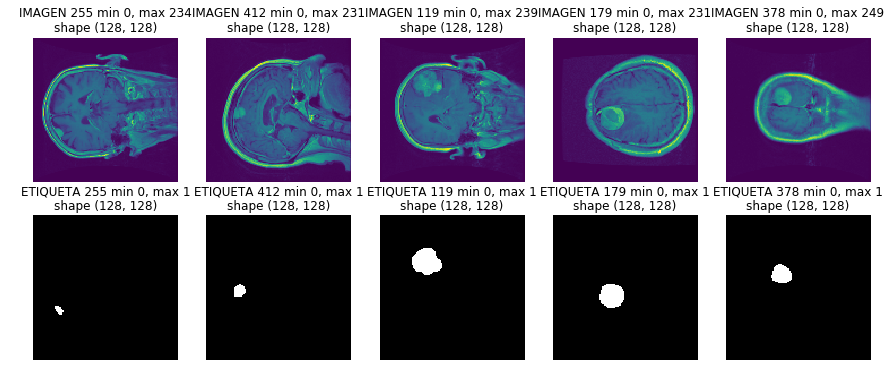

In [11]:
#Mostrar las imagenes reescaladas
def show_img(img, title="", cmap=None, details=True):
    plt.imshow(img, cmap=cmap)
    if details:
        plt.title("%s min %d, max %d\nshape %s"%(title, np.min(img), np.max(img), str(img.shape)))
    else:
        plt.title(title)
    plt.axis("off")
    
plt.figure(figsize=(15,6))
ids = np.random.permutation(len(X_train))[:5]
for c,i in enumerate(ids):
    plt.subplot(2,5,c+1)
    show_img(X_train[i].mean(axis=2), "IMAGEN %d"%i)
    plt.subplot(2,5,c+6)
    show_img(np.squeeze(Y_train[i]), "ETIQUETA %d"%i, cmap=plt.cm.Greys_r)

In [12]:
#Funcion para validad el contorno de la segmentacion
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### Arquitectura de Red Neuronal Convolucional (CNN)
Se contruyó una arquitectura de red neuronal basada en U-Net: Convolutional Networks for Biomedical Image Segmentation. La selección de esta arquitectura se hizo en base al éxito comprobado para el procesamiento de imágenes biomédicas. La arquitectura suple las necesidades de análisis, teniendo un buen comportamiento a deformaciones elásticas en las imágenes de entrada disponibles. La arquitectura permite que el algoritmo se adapte a las deformaciones presentes en la adquisición de las MRI.

In [13]:
#funcion para establecer el modelo
def get_model():
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) #Capa de entrada
    s = Lambda(lambda x: x / 255) (inputs)                #Capa no entrenable o funcion (normaliza las ima)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) #convolucion
    c1 = Dropout(0.1) (c1)                                                                        #regularizacion 0
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)#convolucion
    p1 = MaxPooling2D((2, 2)) (c1)                                                                #reduccion de dim

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    
    return model

In [14]:
#Obtener el modelo y el resumen del modelo
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

## Pesos de la primera capa
Los pesos que se generan en la primera capa se obsevan en la siguiente sección. Se hace una inspección grafica de los pesos obtenidos, para posteriormente comparar este resultado con las salidas después de entrenar la red neuronal.

In [15]:
import mlutils
reload(mlutils)

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<module 'mlutils' from 'mlutils.pyc'>

('Forma de la primera capa ', (3, 3, 3, 16))


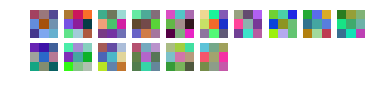

In [16]:
#mostramos los pesos de la primera capa
w = model.get_weights()
print ('Forma de la primera capa ', np.shape(w[0]))
mlutils.display_imgs(w[0])

### Cargar el modelo pre-entrenado
Este proceso consiste en importar los resultados obtenidos en un entrenamiento previo de nuestro modelo. El algoritmo se encarga automaticamente de bajar el archivo al espacio de trabajo desde donde ejecuta este notebook

In [17]:
#Descargar imagenes
import os.path as path
if path.exists('neuroimageSegmentation.h5'):   
    print ('El archivo ya existe')
else:
    !wget -nc https://www.dropbox.com/s/0wpu59ajs2t8ufx/neuroimageSegmentation.zip?dl=1
    !unzip neuroimageSegmentation.zip?dl=1
    !rm -r neuroimageSegmentation.zip?dl=1

El archivo ya existe


### Ajustar el modelo
Este paso no es necesario si la red ya está entrenada
En este proceso se entrena la arquitectura, cuenta con 50 epocas con un batch de 16.

In [ ]:
#Se entrenan los pesos del modelos
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('neuroimageSegmentation.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

('Forma de la primera capa ', (3, 3, 3, 16))


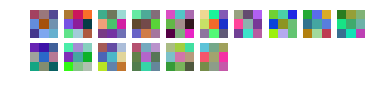

In [18]:
#mostramos los pesos de la primera capa
w = model.get_weights()
print ('Forma de la primera capa ', np.shape(w[0]))
mlutils.display_imgs(w[0])

### Validación de las predicciones
En esta sección se presentan los resultados obtenidos con los datos de validación, entrenamiendo y prueba. Los datos de entrenamiento son el 90% de los datos X_train, el 10% restante pertenecen a los datos de validación. De igual manera se observan las predicciones obtenidas con las imágenes de prueba.   Las "imágenes" de predicción entregan un porcenteje de acierto. Para poder comparar este resultado entregado con las mascaras delineadas por los radiólogos es necesario convertir el resultado de predicción a un forma comparable. Usamos un umbral para binarizar el resultado y poder hacer una inspección grafica de los resultados predichos con los valores reales.

In [19]:
# Prediccion, entremiento, validacion y prueba
model = load_model('neuroimageSegmentation.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Umbralizar la prediccion
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    #Reescala las prediciones a los tamaños originales
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

212/212 [==============================] - 12s 58ms/step


In [20]:
print int(X_train.shape[0]*0.9), 'imagenes de entrenamiento de', len(X_train)

446 imagenes de entrenamiento de 496


### Evaluación de los resultados de entrenamiento
Para evaluar la capacidad de acierto obtenida en la etapa de entrenamiento, se hace una comparación de las áreas segmentadas en esta etapa. Se observan cinco resultados al azar, las gráficas mostradas se ordenan por filas como: Fila 1. Imagen de la resonancia magnética. Fila 2. Área delineada manualmente por un radiólogo experto. Fila 3. Área predicha por la arquitectura.  

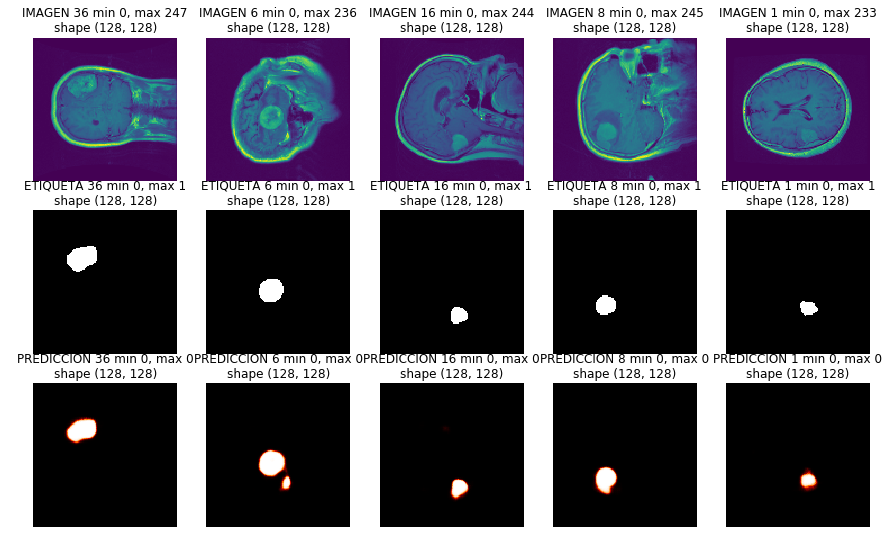

In [21]:
plt.figure(figsize=(15,9))
ids = np.random.permutation(len(preds_val))[:5]
for c,i in enumerate(ids):
    plt.subplot(3,5,c+1)
    show_img(X_train[int(X_train.shape[0]*0.9):][i].mean(axis=2), "IMAGEN %d"%i)
    plt.subplot(3,5,c+6)
    show_img(np.squeeze(Y_train[int(X_train.shape[0]*0.9):][i]), "ETIQUETA %d"%i, cmap=plt.cm.Greys_r)
    plt.subplot(3,5,c+11)
    show_img(np.squeeze(preds_val[i]), "PREDICCION %d"%i, cmap='gist_heat' )

### Evaluación de los resultados obtenidos con datos de evaluación
Los resultados obtenidos en la etapa de evaluación muestran la imagen de la resonancia magnética y las áreas delimitadas por el algoritmo de segmentación. 

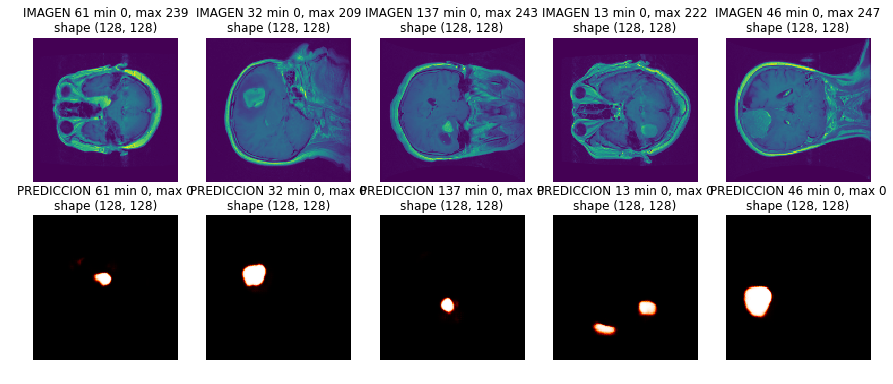

In [22]:
plt.figure(figsize=(15,6))
ids = np.random.permutation(len(preds_test))[:5]
for c,i in enumerate(ids):
    plt.subplot(2,5,c+1)
    show_img(X_test[i].mean(axis=2), "IMAGEN %d"%i)
    plt.subplot(2,5,c+6)
    show_img(np.squeeze(preds_test[i]), "PREDICCION %d"%i, cmap='gist_heat')

###  Resultados globales
Finalmente, para las 212 imágenes de test, fuene necesario compara los resultados predichos por la CNN y la segmentación realizada por los radiólogos. Se dió un porcentaje de concordancia dividiendo el área de unión entre las dos imágenes y el área de intersección de la misma.

In [23]:
OrImg=(preds_test_t[:,:,:,0]+Y_test[:,:,:,0])!=0
Vor=np.sum(np.sum(OrImg, axis=2), axis=1)
AnIma=(preds_test_t[:,:,:,0]*Y_test[:,:,:,0])
Van=np.sum(np.sum(AnIma, axis=2), axis=1)

El siguiente histograma muestra la distribución de las concordancias obtenidas para las 212 imágenes, en donde es claro ver que la mayoría están por encima del 80%, valor que india el poder predictivo del modelo. 

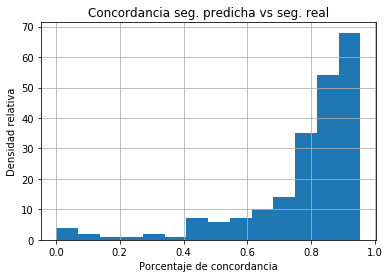

In [24]:
plt.figure()
plt.hist(Van/Vor, 14);
plt.title('Concordancia seg. predicha vs seg. real')
plt.ylabel('Densidad relativa')
plt.xlabel('Porcentaje de concordancia')
plt.grid()

In [26]:
print ('La media del porcetanje de concordancia fue :', np.mean(Van/Vor))

('La media del porcetanje de concordancia fue :', 0.7738726173036681)
